<a href="https://colab.research.google.com/github/geoifg/ssc_araguaia/blob/main/Estimativa_CSS_Araguaia_regressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práticas de regressão de dados para estimativa de Concentração de Sedimentos em Suspensão no Rio Araguaia**

Material: Édipo Cremon (IFG)
Dados: https://doi.org/10.1080/2150704X.2019.1681597

Nesse script iremos utilizar a linguagem de programação R dentro do ambiente Colab que nativamente é para Python.

Ativar o emulador R magic

In [1]:
# activate R magic
%load_ext rpy2.ipython

Toda vez que for rodar um script em R, é necessário colocar o comando: %%R

In [2]:
#Teste
%%R
x <- 42
print(x)

[1] 42


In [3]:
#Pacotes instalados
%%R
str(allPackage <- installed.packages())
allPackage [, c(1,3:5)]

 chr [1:158, 1:16] "IRdisplay" "IRkernel" "pbdZMQ" "repr" "askpass" ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:158] "IRdisplay" "IRkernel" "pbdZMQ" "repr" ...
  ..$ : chr [1:16] "Package" "LibPath" "Version" "Priority" ...
              Package         Version    Priority     
IRdisplay     "IRdisplay"     "1.1"      NA           
IRkernel      "IRkernel"      "1.3"      NA           
pbdZMQ        "pbdZMQ"        "0.3-7"    NA           
repr          "repr"          "1.1.4"    NA           
askpass       "askpass"       "1.1"      NA           
assertthat    "assertthat"    "0.2.1"    NA           
backports     "backports"     "1.4.1"    NA           
base64enc     "base64enc"     "0.1-3"    NA           
bit           "bit"           "4.0.4"    NA           
bit64         "bit64"         "4.0.5"    NA           
blob          "blob"          "1.2.3"    NA           
brew          "brew"          "1.0-7"    NA           
brio          "brio"          "1.1.3"    NA          

In [4]:
#%%R
#library()

Aqui iremos ler os arquivos que estão em uma planilha no formato .csv que consta a reflectância ToA (top of atmosphere) das bandas espectrais do TM/Landsat, razões de banda e a concentração de sedimentos em suspensão.

In [5]:
%%R
araguaia_ToA<-read.csv('https://raw.githubusercontent.com/geoifg/ssc_araguaia/main/TOA_Araguaia.csv', header = T, sep = ';')
str(araguaia_ToA)

'data.frame':	68 obs. of  18 variables:
 $ Station          : chr  "Araguaiana" "Araguaiana" "Araguaiana" "Araguaiana" ...
 $ Station_cat      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Sample_date      : chr  "18/06/1994" "30/06/1997" "29/06/1998" "05/10/2004" ...
 $ Dif              : int  -6 6 -6 1 -1 1 -6 -6 7 7 ...
 $ Image_date       : chr  "12/06/1994" "06/07/1997" "23/06/1998" "06/10/2004" ...
 $ SSC              : num  26.4 73.3 31.2 20.7 179.9 ...
 $ B1               : num  0.0915 0.0977 0.1009 0.1025 0.0955 ...
 $ B2               : num  0.0836 0.0947 0.0949 0.0976 0.1009 ...
 $ B3               : num  0.0743 0.087 0.0754 0.0834 0.1123 ...
 $ B4               : num  0.0455 0.0449 0.0431 0.0475 0.0649 ...
 $ B5               : num  0.01476 0.01303 0.01419 0.01622 0.00816 ...
 $ B4.3by2.1        : num  0.684 0.686 0.605 0.654 0.902 ...
 $ B3_B1            : num  0.812 0.891 0.747 0.814 1.175 ...
 $ B2_B1            : num  0.914 0.969 0.941 0.952 1.056 ...
 $ B3_B2            : num  0.8

Transformar dados - o comando str indica que algumas colunas ficaram no formato character (chr)

In [6]:
%%R
#converter coluna tipo de dado em date 
#criar nova coluna de data
araguaia_ToA$Sample_date<-as.Date(araguaia_ToA$Sample_date, "%d/%m/%Y")
head(araguaia_ToA)

araguaia_ToA$Image_date<-as.Date(araguaia_ToA$Image_date, "%d/%m/%Y")
str(araguaia_ToA)

'data.frame':	68 obs. of  18 variables:
 $ Station          : chr  "Araguaiana" "Araguaiana" "Araguaiana" "Araguaiana" ...
 $ Station_cat      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Sample_date      : Date, format: "1994-06-18" "1997-06-30" ...
 $ Dif              : int  -6 6 -6 1 -1 1 -6 -6 7 7 ...
 $ Image_date       : Date, format: "1994-06-12" "1997-07-06" ...
 $ SSC              : num  26.4 73.3 31.2 20.7 179.9 ...
 $ B1               : num  0.0915 0.0977 0.1009 0.1025 0.0955 ...
 $ B2               : num  0.0836 0.0947 0.0949 0.0976 0.1009 ...
 $ B3               : num  0.0743 0.087 0.0754 0.0834 0.1123 ...
 $ B4               : num  0.0455 0.0449 0.0431 0.0475 0.0649 ...
 $ B5               : num  0.01476 0.01303 0.01419 0.01622 0.00816 ...
 $ B4.3by2.1        : num  0.684 0.686 0.605 0.654 0.902 ...
 $ B3_B1            : num  0.812 0.891 0.747 0.814 1.175 ...
 $ B2_B1            : num  0.914 0.969 0.941 0.952 1.056 ...
 $ B3_B2            : num  0.889 0.919 0.794 0.855 1.112 ...
 $ 

In [7]:
%%R
#converter a coluna Station_cat para factor (dado categórico)
araguaia_ToA$Station_cat <-as.factor(araguaia_ToA$Station_cat)
str(araguaia_ToA)

'data.frame':	68 obs. of  18 variables:
 $ Station          : chr  "Araguaiana" "Araguaiana" "Araguaiana" "Araguaiana" ...
 $ Station_cat      : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Sample_date      : Date, format: "1994-06-18" "1997-06-30" ...
 $ Dif              : int  -6 6 -6 1 -1 1 -6 -6 7 7 ...
 $ Image_date       : Date, format: "1994-06-12" "1997-07-06" ...
 $ SSC              : num  26.4 73.3 31.2 20.7 179.9 ...
 $ B1               : num  0.0915 0.0977 0.1009 0.1025 0.0955 ...
 $ B2               : num  0.0836 0.0947 0.0949 0.0976 0.1009 ...
 $ B3               : num  0.0743 0.087 0.0754 0.0834 0.1123 ...
 $ B4               : num  0.0455 0.0449 0.0431 0.0475 0.0649 ...
 $ B5               : num  0.01476 0.01303 0.01419 0.01622 0.00816 ...
 $ B4.3by2.1        : num  0.684 0.686 0.605 0.654 0.902 ...
 $ B3_B1            : num  0.812 0.891 0.747 0.814 1.175 ...
 $ B2_B1            : num  0.914 0.969 0.941 0.952 1.056 ...
 $ B3_B2            : num  0.889 0.919 0.

Em virtude da análise entre a melhor variável preditiva e a CSS apresentar comportamento de saturação, vamos fazer uma transformação nos dados de CSS pelo logaritmo natural e criar uma nova coluna com a variável "LN_SSC".

In [8]:
%%R
araguaia_ToA$LN_SSC <- log(araguaia_ToA$SSC)
head(araguaia_ToA)

     Station Station_cat Sample_date Dif Image_date    SSC       B1       B2
1 Araguaiana           1  1994-06-18  -6 1994-06-12  26.35 0.091464 0.083625
2 Araguaiana           1  1997-06-30   6 1997-07-06  73.32 0.097681 0.094684
3 Araguaiana           1  1998-06-29  -6 1998-06-23  31.19 0.100852 0.094889
4 Araguaiana           1  2004-10-05   1 2004-10-06  20.70 0.102493 0.097574
5 Araguaiana           1  2008-05-02  -1 2008-05-01 179.91 0.095511 0.100912
6 Araguaiana           1  2008-07-03   1 2008-07-04  24.18 0.095255 0.088347
        B3       B4       B5 B4.3by2.1  B3_B1  B2_B1  B3_B2  B4_B3 B3_B2.B1
1 0.074306 0.045477 0.014756    0.6841 0.8124 0.9143 0.8886 0.6120   0.4244
2 0.087045 0.044917 0.013032    0.6860 0.8911 0.9693 0.9193 0.5160   0.4525
3 0.075356 0.043143 0.014191    0.6054 0.7472 0.9409 0.7941 0.5725   0.3850
4 0.083444 0.047490 0.016221    0.6545 0.8141 0.9520 0.8552 0.5691   0.4171
5 0.112252 0.064900 0.008164    0.9019 1.1753 1.0565 1.1124 0.5782   0.5715
6 0.0

 [1] "Station"           "Station_cat"       "Sample_date"      
 [4] "Dif"               "Image_date"        "SSC"              
 [7] "B1"                "B2"                "B3"               
[10] "B4"                "B5"                "B4.3by2.1"        
[13] "B3_B1"             "B2_B1"             "B3_B2"            
[16] "B4_B3"             "B3_B2.B1"          "B3.B2.B1_B3.B2.B1"
[19] "LN_SSC"           


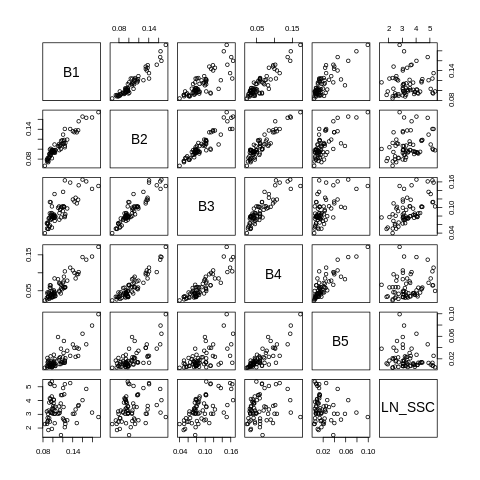

In [9]:
#Para gerar uma matriz de gr?ficos de dispers?o entre as vari?veis do data.frame podemos usar o comando pairs()
%%R
pairs(araguaia_ToA[c("B1", "B2", "B3", "B4", "B5", "LN_SSC")])
names(araguaia_ToA)

Trabalhando com pacotes
Instalando o pacote "corrplot"

(as ‘lib’ is unspecified)







	‘/tmp/RtmpaEtCns/downloaded_packages’




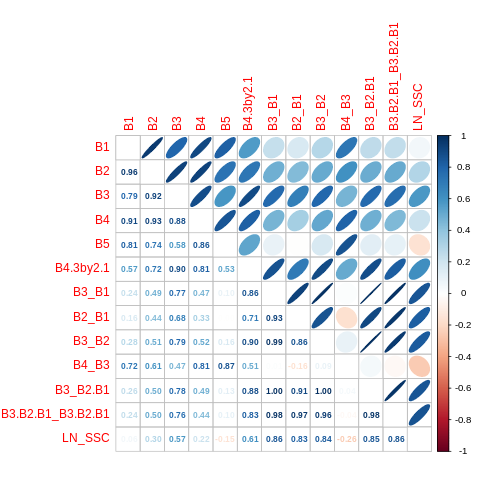

In [10]:
%%R
install.packages("corrplot")

#Chamando o pacote "corrplot"
library(corrplot)

# primeiro fazemos a matriz de correla??o
M <- cor(araguaia_ToA[7:19])
M
corrplot.mixed(M, lower = "number", number.cex = .7, upper = "ellipse", tl.pos = "lt")

Gráfico entre a razão de banda e a concentração de sedimentos em suspensão

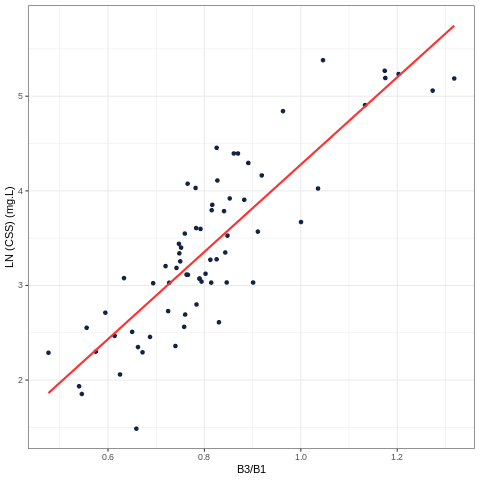

In [11]:
%%R
#Grafico entre LN (CSS) e a razão de bandas B3/B1
library(ggplot2)
ggplot(araguaia_ToA) +
  aes(x = B3_B1, y = LN_SSC) +
  geom_point(shape = "circle", size = 1.5, colour = "#112446") +
  theme_bw() +
  geom_smooth(formula=y~x,method=lm,
              col="firebrick1",se=FALSE) +
  labs(x = "B3/B1", y = "LN (CSS) (mg.L)") 


Agora já notamos um comportamento de saturação.

Calculando uma matriz de correlação. Vamos utilizar o pacote caret.




In [12]:
%%R
install.packages("caret")
library(caret)
# calcula a matriz de correlacao
correlationMatrix <- cor(araguaia_ToA[7:19])
# mostrar osresultados da matriz de correlacao
print(correlationMatrix)


(as ‘lib’ is unspecified)

































































































































	‘/tmp/RtmpaEtCns/downloaded_packages’




                          B1        B2        B3        B4           B5
B1                1.00000000 0.9555081 0.7917236 0.9084534  0.811585354
B2                0.95550809 1.0000000 0.9248826 0.9252395  0.735529706
B3                0.79172364 0.9248826 1.0000000 0.8821013  0.583972420
B4                0.90845337 0.9252395 0.8821013 1.0000000  0.857798499
B5                0.81158535 0.7355297 0.5839724 0.8577985  1.000000000
B4.3by2.1         0.56778163 0.7224799 0.8989135 0.8112493  0.526305858
B3_B1             0.23631717 0.4868237 0.7714737 0.4675595  0.099449272
B2_B1             0.16100819 0.4398909 0.6832456 0.3318195 -0.001844809
B3_B2             0.28045956 0.5053682 0.7853509 0.5171338  0.164922061
B4_B3             0.72301232 0.6071862 0.4672033 0.8096744  0.865066645
B3_B2.B1          0.25589321 0.4969235 0.7798041 0.4891379  0.127648794
B3.B2.B1_B3.B2.B1 0.24207398 0.5004173 0.7600553 0.4410184  0.101022398
LN_SSC            0.05775995 0.2962460 0.5725445 0.2183617 -0.15

In [13]:
%%R
# encontrar atributos que sejam altamente correlacionados (idealmente >0,7)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.7)
# atributos altamente correlacionados
print(highlyCorrelated)

 [1]  3  6  9 11  7  4  2  8 13  1  5


Metodologia para selecionar variáveis que não sejam colineares.

In [14]:
%%R
install.packages("randomForest")
library(caret)
library(randomForest)
# define the control using a random forest selection function
control <- rfeControl(functions=rfFuncs, method="cv", number=5)
# run the RFE algorithm
results <- rfe(araguaia_ToA[7:18], araguaia_ToA[,19], sizes=c(7:18), rfeControl=control)
# summarize the results
print(results)
# list the chosen features
predictors(results)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpaEtCns/downloaded_packages’



Attaching package: ‘randomForest’



    margin





Recursive feature selection

Outer resampling method: Cross-Validated (5 fold) 

Resampling performance over subset size:

 Variables   RMSE Rsquared    MAE  RMSESD RsquaredSD   MAESD Selected
         7 0.4608   0.7553 0.3581 0.08659     0.1161 0.08309         
         8 0.4508   0.7668 0.3502 0.08019     0.1122 0.08158        *
         9 0.4555   0.7649 0.3540 0.07495     0.1052 0.07480         
        10 0.4521   0.7684 0.3493 0.07052     0.1015 0.07152         
        11 0.4534   0.7670 0.3567 0.06735     0.1052 0.06829         
        12 0.4542   0.7711 0.3528 0.06964     0.1007 0.07350         

The top 5 variables (out of 8):
   B3.B2.B1_B3.B2.B1, B3_B1, B3_B2, B3_B2.B1, B2_B1

[1] "B3.B2.B1_B3.B2.B1" "B3_B1"             "B3_B2"            
[4] "B3_B2.B1"          "B2_B1"             "B5"               
[7] "B4_B3"             "B4.3by2.1"        


Aplicando um modelo de regressão linear com validação cruzada (Leave-One-Out Cross-Validation - LOOCV).

In [28]:
%%R
#Modelo de regresscao linear "LM - linear model" com o pacote caret
set.seed(100)
regressControl  <- trainControl(method="LOOCV",
                                number = 1) 

regress <- train(LN_SSC~B3.B2.B1_B3.B2.B1+B3_B1+B3_B2.B1+B3_B2+B2_B1+B5+B4_B3+B4.3by2.1,
                 data = araguaia_ToA,
                 method  = "lm",
                 trControl = regressControl,
                 metric = "RMSE")


print(regress)

Linear Regression 

68 samples
 8 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 67, 67, 67, 67, 67, 67, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.4390931  0.7671022  0.3506505

Tuning parameter 'intercept' was held constant at a value of TRUE


Aplicando um modelo de regressão linear com validação cruzada com variável categórica (estações)

In [29]:
%%R
#Modelo de regresscao linear "LM - linear model" com o pacote caret
set.seed(100)
regressControl  <- trainControl(method="LOOCV",
                                number = 1)

regress <- train(LN_SSC~Station_cat+B3.B2.B1_B3.B2.B1+B3_B1+B3_B2.B1+B3_B2+B2_B1+B5+B4_B3+B4.3by2.1,
                 data = araguaia_ToA,
                 method  = "lm",
                 trControl = regressControl,
                 metric = "RMSE")


print(regress)

Linear Regression 

68 samples
 9 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 67, 67, 67, 67, 67, 67, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.4388033  0.7691171  0.3431986

Tuning parameter 'intercept' was held constant at a value of TRUE


In [30]:
%%R
#Vericando os coeficientes
regress$finalModel


Call:
lm(formula = .outcome ~ ., data = dat)

Coefficients:
      (Intercept)       Station_cat1  B3.B2.B1_B3.B2.B1              B3_B1  
         17.42271            0.20158           12.99644          -33.52468  
         B3_B2.B1              B3_B2              B2_B1                 B5  
        183.82717          -58.86203          -18.05434           -0.04622  
            B4_B3          B4.3by2.1  
         -3.21984            3.72797  



A equação ficaria assim:
LN(CSS)=17.42271+(B3/B2+B1*183.82717)+(Estação*0.20158)-((B3/B2)*58.86203 )-((B3+B2-B1)/(B3+B2+B1)*12.99644)-((B2/B1)*18.05434)-((B4/B3)*3.21984)-((B(4+3)/(2+1))*3.21984)-(B5*0.04622)-((B3/B1)*33.52468)




Para eliminar o LN e obter apenas a CSS, basta "jogá-lo" para o outro lado da fórmula pelo número neperiano (e=2.71828182845). O número neperiano é a base do logaritmo natural (LN).
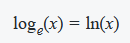

Verificando quais variáveis foram mais importantes

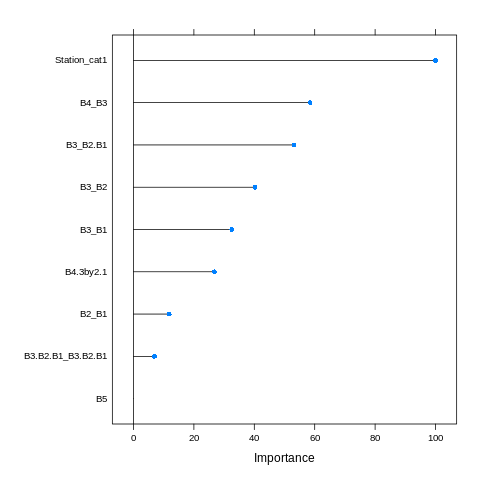

In [31]:
%%R
#Importancia das variaveis
importancia <- varImp(regress)
plot(importancia)

Aplicando o modelo

In [32]:
%%R
#Aplicando modelo nos dados de teste (simulacao)
reg_pred <- predict(regress, araguaia_ToA, type="raw")
araguaia_ToA$LN_SSC_est <- reg_pred

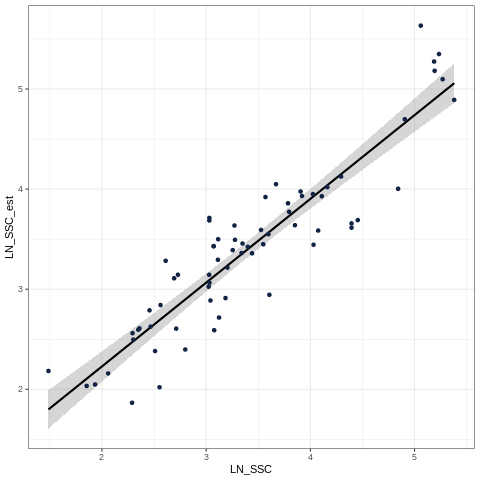

In [33]:
%%R
#Grafico entre observado vs estimado
ggplot(araguaia_ToA) +
  aes(x = LN_SSC, y = LN_SSC_est) +
  geom_smooth(formula=y ~x, method = lm, col="black") +
  geom_point(shape = "circle", size = 1.5, colour = "#112446") +
  theme_bw()

Removendo o logaritmo natural (LN) da estimativa

In [34]:
%%R
araguaia_ToA$SSC_est <- 2.71828182845^araguaia_ToA$LN_SSC_est

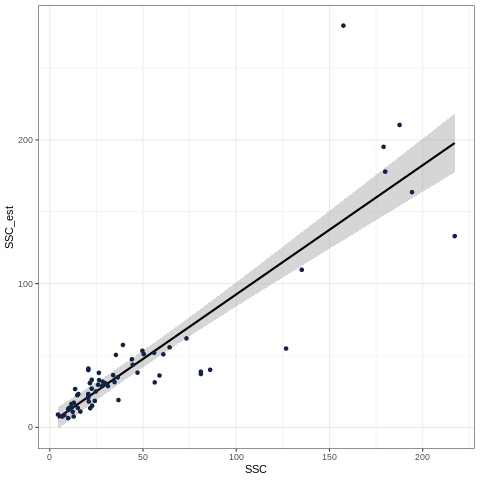

In [35]:
%%R
#Grafico entre observado vs estimado
ggplot(araguaia_ToA) +
  aes(x = SSC, y = SSC_est) +
  geom_smooth(formula=y ~x, method = lm, col="black") +
  geom_point(shape = "circle", size = 1.5, colour = "#112446") +
  theme_bw()

Aplicando um modelo de regressão linear com validação cruzada com variável categórica (estações) e usando um poderoso algoritmo: Random Forest

In [36]:
%%R
#Modelo de regresscao linear "LM - linear model" com o pacote caret
set.seed(100)
regressControl  <- trainControl(method="LOOCV",
                                number = 1) 

regress_rf <- train(LN_SSC~Station_cat+B3.B2.B1_B3.B2.B1+B3_B1+B3_B2.B1+B3_B2+B2_B1+B5+B4_B3+B4.3by2.1,
                 data = araguaia_ToA,
                 method  = "rf",
                 trControl = regressControl,
                 metric = "RMSE")


print(regress_rf)

Random Forest 

68 samples
 9 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 67, 67, 67, 67, 67, 67, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE      
  2     0.4267000  0.7775192  0.3379318
  5     0.4369024  0.7663694  0.3452145
  9     0.4445905  0.7584004  0.3499453

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 2.


Nem sempre o que está na moda é melhor que um clássico.